<a href="https://colab.research.google.com/github/glaucio-rocha/ciencia_de_dados/blob/main/MVP/MVP-Sprint_II-pt2-Deep_learning-.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Machine Learning e Deep Learning (Sprint 2) - parte 2 (DL)
## Ciência de Dados & Analytics
### Glaucio A. Rocha
### 2023-07-23
---

In [ ]:
!pip install tflearn tensorflow==2.8.0 keras==2.8.0

### Definição do Problema

#### Descrição do problema
A grande dificuldade do monitoramento, fiscalização e gerenciamento de ativos, ou eventos, em localidades remotas é um problema importante em um país com dimensões continentais com o Brasil. A existência de atualizaçãoes diárias (e, provavelmente, daqui a pouco tempo, horárias) de imagens provenientes de satélites é parte da solução para este problema. Por outro lado, a incapacidade de realizar esse serviço de identificação por humanos, dada a quantidade e taxa de atualização, parece ser um empecilho para viabilizar economicamente um serviço como esse.

#### Premissas e hipóteses

A identificação de objetos relevantes em imagens de satélite de maneira automatizada, usando algoritmos de visão computacional e Deep learning, se apresenta com o uma solução possível para a construção de base de dados atualizadas e serviços de monitoramento e detecção de mudanças.


#### Restrições e condições

Para este notebook foi escolhido um dataset que apresenta aviões de diversos tipos identificados em imagens de satélite.


#### Descrição do dataset

O Dataset usado neste notebook foi o planesnet. Os aviões estão armazenados em imagens RGB de 20x20 pixels, separadas em duas classes: "1", que representam as imagens que contém aviões, e "0", todas as que não os contém.

In [ ]:
import os
import math
import sklearn
import collections
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import LearningRateScheduler

import requests
import gzip
import pickle

#### Carga de Dados


O dataset está armazenado no formato pickle, que contém a estrutura de dados com as imagens RGB 20x20, os "labels" 1 ou 0, além de outras informações associadas.



In [ ]:
# Carga de Dados

url = "https://raw.githubusercontent.com/rhammell/planesnet/master/planesnet.pklz"

response = requests.get(url)

# Verificação de Download OK
if response.status_code == 200:

    # Carrega pckle descompactado para o dataset
    dataset = pickle.loads(gzip.decompress(response.content))

#### Separação dos dados (treino e teste)
O conjunto de dados foi preparado para ter um subconjunto de treino, outro de teste e mais um de validação.

In [ ]:
# reorganizando a informação para X e Y
X = np.array(dataset['data']) / 255.
X = X.reshape([-1,3,20,20]).transpose([0,2,3,1])
Y = np.array(dataset['labels'])



#### Visualização dos dados

Abaixo, um conjunto de imagens com a classe "1" (imagem contém um avião)

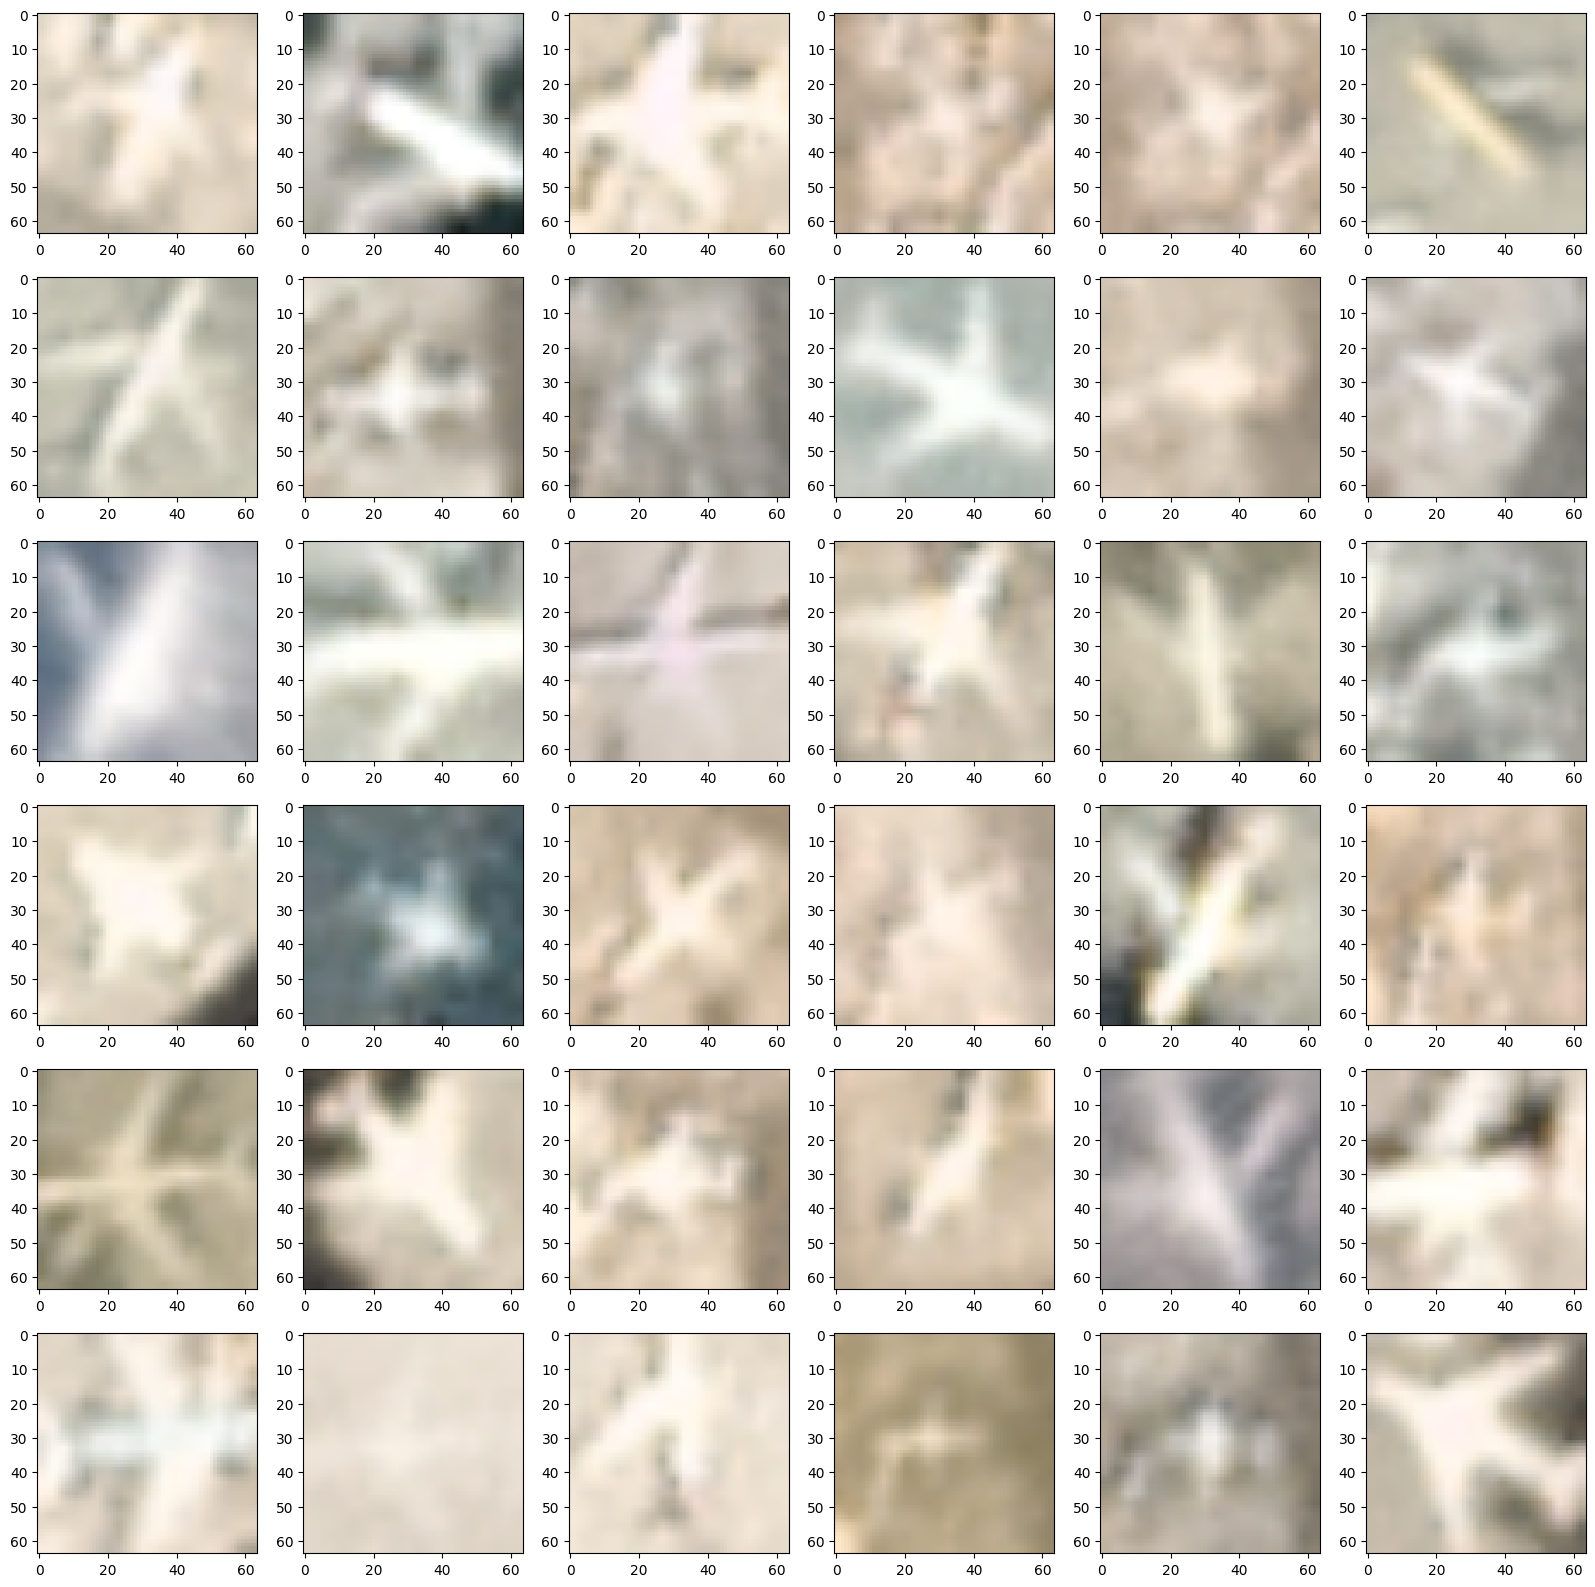

In [ ]:
# parametros para apresentação em tela
i_width = 64
i_height = 64

# seleção para escolha de imagens com classe "1"
idx = [index for index, element in enumerate(dataset["labels"]) if element == 1]
imgp = np.array([dataset['data'][i] for i in idx]).astype('uint8')
y_planes = np.array([dataset['labels'][i] for i in idx])
y_planes = np.where(y_planes==1, 12, y_planes)
x_planes = imgp.reshape([-1,3, 20, 20])
x_planes = np.moveaxis(x_planes,1,3)

# figura 20x20 esticada para i_width x i_height
x_planes = tf.image.resize(x_planes, [i_height, i_width]).numpy()

fig1, axes = plt.subplots(6,6, figsize=(20,20))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_planes[i].astype('uint8'))

In [ ]:
# Split das infomrções em treino, teste e validação.
X_train, X_temp, y_train, y_temp = train_test_split(X,Y,test_size=0.20, random_state=42,shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp,y_temp,test_size=0.50, random_state=42,shuffle=True)



os comandos a seguir, copiados do repositório que explica o dataset, realizam uma operação de "augmentation" manual (sem usar outras bibliotecas) realizando 3 rotações de 90 graus em cada avião, adicionando-os ao conjunto de treino (102400 imagens).

In [ ]:
x_train1 = np.rot90(X_train,k=1,axes=(1,2))
x_train2 = np.rot90(X_train,k=2,axes=(1,2))
x_train3 = np.rot90(X_train,k=3,axes=(1,2))

X_train = np.append(X_train,x_train1,axis=0)
X_train = np.append(X_train,x_train2,axis=0)
X_train = np.append(X_train,x_train3,axis=0)

y_train = np.append(y_train,y_train)
y_train = np.append(y_train,y_train)

print(X_train.shape)

(102400, 20, 20, 3)


A rede CNN foi projetada com uma camada de entrada com ativação usando 'tanh', seguida por duas camadas 'relu' e uma camada densa com ativação sigmóide

In [ ]:
import tensorflow as tf
model = Sequential()

model.add(Conv2D(16, 2, padding='valid',input_shape=(20,20,3)))
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, 3, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, 2, kernel_initializer='random_uniform', padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 19, 19, 16)        208       
                                                                 
 batch_normalization_3 (Batc  (None, 19, 19, 16)       64        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 19, 19, 16)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 16)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 32)        

#### Treino

A escolha de 30 épocas para o treino foi feita a partir de avaliação do comportamento nas primeiras versões deste script.

In [ ]:
log = model.fit(X_train, y_train, shuffle=True, validation_data=(X_valid, y_valid), epochs=30)

Epoch 1/30
3200/3200 [==============================] - 26s 5ms/step - loss: 0.2150 - binary_accuracy: 0.9117 - val_loss: 0.1541 - val_binary_accuracy: 0.9406
Epoch 2/30
3200/3200 [==============================] - 16s 5ms/step - loss: 0.1311 - binary_accuracy: 0.9487 - val_loss: 0.1130 - val_binary_accuracy: 0.9575
Epoch 3/30
3200/3200 [==============================] - 16s 5ms/step - loss: 0.1114 - binary_accuracy: 0.9565 - val_loss: 0.1098 - val_binary_accuracy: 0.9584
Epoch 4/30
3200/3200 [==============================] - 19s 6ms/step - loss: 0.0999 - binary_accuracy: 0.9614 - val_loss: 0.0929 - val_binary_accuracy: 0.9659
Epoch 5/30
3200/3200 [==============================] - 20s 6ms/step - loss: 0.0921 - binary_accuracy: 0.9642 - val_loss: 0.0912 - val_binary_accuracy: 0.9681
Epoch 6/30
3200/3200 [==============================] - 16s 5ms/step - loss: 0.0860 - binary_accuracy: 0.9674 - val_loss: 0.0804 - val_binary_accuracy: 0.9709
Epoch 7/30
3200/3200 [========================

### Avaliação de resultados
#### Relatório de avaliação (Acurácia)

O relatório apresenta uma acurácia acima de 98%, com precisão, recall e f1 na mesma faixa.

In [ ]:
y_pred = model.predict(X_test)
# saída da sigmóide sendo transformada em 1 ou 0
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0
y_pred=np.asarray(y_pred, dtype=bool)
target_names = ['Sem Avião', 'Avião']
print(classification_report(y_test, y_pred, target_names=target_names))
print('Acurácia:',accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

   Sem Avião       0.99      0.99      0.99      2389
       Avião       0.96      0.98      0.97       811

    accuracy                           0.98      3200
   macro avg       0.98      0.98      0.98      3200
weighted avg       0.98      0.98      0.98      3200

Acurácia: 0.984375


Os gráficos de Acurácia e Loss apresentam um comportamento que indicam a convergência entre os conjuntos de dados de treino e validação. Os  valores se apresentam aceitáveis para o objetivo e prazo de execução do exercício.

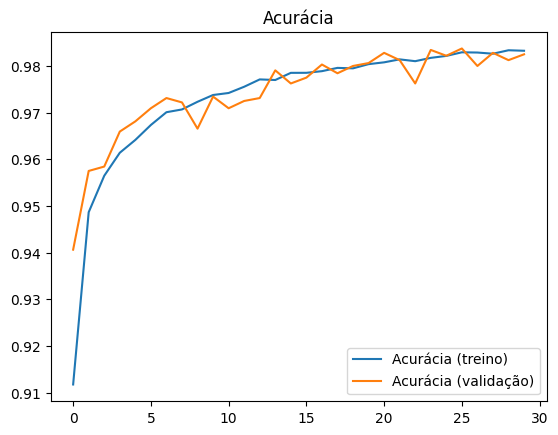

In [ ]:
#Acurácia no conjunto de treion vc conjunto de validação
tac = log.history['binary_accuracy']
vac = log.history['val_binary_accuracy']
plt.plot(np.linspace(0,len(tac)-1,len(tac)),tac, label='Acurácia (treino)')
plt.plot(np.linspace(0,len(vac)-1,len(vac)),vac, label='Acurácia (validação)')
plt.title('Acurácia')
plt.legend();

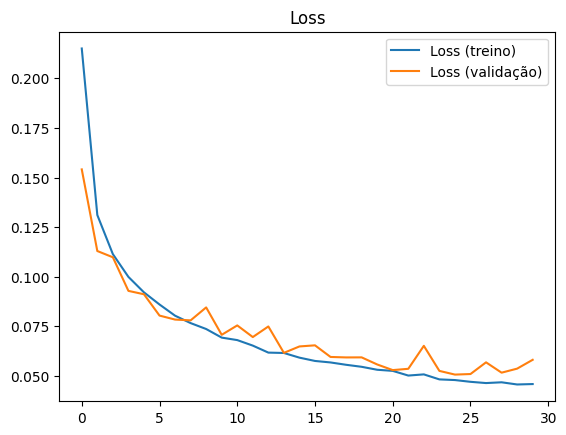

In [ ]:
#Acurácia no conjunto de treion vc conjunto de validação
tlo = log.history['loss']
vlo = log.history['val_loss']
plt.plot(np.linspace(0,len(tlo)-1,len(tlo)),tlo, label='Loss (treino)')
plt.plot(np.linspace(0,len(vlo)-1,len(vlo)),vlo, label='Loss (validação)')
plt.title('Loss')
plt.legend();

## Conclusões

A arquitetura da rede CNN selecionada para uso neste Dataset se mostrou bastante eficiente. A avaliação das métricas sugere que este MVP pode ser o ponto de partida para uma especialização maior dos algoritmos e parâmetros utilizados.

A construção de um Dataset voltado para um determinado assunto mais específico, como o agronegócio, atividades de seguradoras, ou quaisquer tarefas de monitoramento do espaço geográfico, pode ser realizada para auxiliar na evolução deste modelo.

A escolha de uma fonte de dados de satélite, mais acessível, pode restringir os tipos (e tamanhos) dos objetos a serem detectados.